# Устанавливаем необходимые библиотеки

In [1]:
!pip install -U seaborn

In [2]:
!pip install -U pandas

In [3]:
!pip install catboost

# Скачиваю и извлекаю из архива данные

In [4]:
!wget https://lodmedia.hb.bizmrg.com/case_files/982129/train_dataset_Самолет.zip

--2023-06-25 08:16:36--  https://lodmedia.hb.bizmrg.com/case_files/982129/train_dataset_%D0%A1%D0%B0%D0%BC%D0%BE%D0%BB%D0%B5%D1%82.zip
Распознаётся lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)… 95.163.53.117
Подключение к lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 291913 (285K) [application/zip]
Сохранение в: «train_dataset_Самолет.zip.7»

train_dataset_Самол 100%[===================>] 285,07K  --.-KB/s    за 0,1s    

2023-06-25 08:16:37 (2,12 MB/s) - «train_dataset_Самолет.zip.7» сохранён [291913/291913]



In [5]:
!unzip -o train_dataset_Самолет.zip -x

Archive:  train_dataset_Самолет.zip
  inflating: CHMF Акции.csv     
  inflating: MAGN Акции.csv     
  inflating: NLMK Акции.csv     
  inflating: test.xlsx               
  inflating: train.xlsx              
  inflating: Грузоперевозки.xlsx  
  inflating: Данные рынка стройматериалов.xlsx  
  inflating: Индекс LME.xlsx   
  inflating: Макропоказатели.xlsx  
  inflating: Показатели рынка металла.xlsx  
  inflating: Топливо.xlsx     
  inflating: Цены на сырье.xlsx  


# Подключание необходимых библиотек

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from catboost import  CatBoostRegressor, Pool
from catboost import Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import train_test_split, KFold
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.metrics import mean_squared_error

target = 'Цена на арматуру'

# Загрузка данных, колонка 'is_train' понадобится в дальнейшем для раздения тренировочных и тестовых данных.

In [7]:
dtrain = pd.read_excel('train.xlsx')
dtrain['is_train'] = 1
dtrain.head(3)

,dt,Цена на арматуру,is_train
0,2015-01-05,32900,1
1,2015-01-12,32500,1
2,2015-01-19,32000,1


In [8]:
dtrain['dt'].min(), dtrain['dt'].max()

(Timestamp('2015-01-05 00:00:00'), Timestamp('2022-08-29 00:00:00'))

In [9]:
dtest = pd.read_excel('test.xlsx')
dtest['is_train'] = 0
dtest.head(3)

,dt,Цена на арматуру,is_train
0,2022-09-05,46000,0
1,2022-09-12,46000,0
2,2022-09-19,46000,0


# Создаю общий датасет из тренировоных и тестовых данных

In [10]:
df = pd.concat([dtrain, dtest], ignore_index = True)
df.head(3)

,dt,Цена на арматуру,is_train
0,2015-01-05,32900,1
1,2015-01-12,32500,1
2,2015-01-19,32000,1


# Загрузка данных, их преобразование и объединение с общим датасетом.

In [11]:
files = [
    'CHMF Акции.csv',
    'Индекс LME.xlsx',
    'Цены на сырье.xlsx',
    'Топливо.xlsx',
    'Показатели рынка металла.xlsx',
    'Макропоказатели.xlsx',
    'Данные рынка стройматериалов.xlsx',
    'Грузоперевозки.xlsx',
    'NLMK Акции.csv',
    'MAGN Акции.csv'
]

for file in files:
    print(file)
    if 'xlsx' in file:
        temp = pd.read_excel(f'{file}')
    elif file == 'CHMF Акции.csv':
        temp = pd.read_csv(f'{file}')
        temp['dt'] = temp['Date'].apply(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1])
        del temp['Date']
        temp['dt'] = pd.to_datetime(temp['dt'])
        
    if file == 'Индекс LME.xlsx':
        temp = temp.rename(columns={"дата": "dt"})
        
    df = df.merge(temp, 'left', on = 'dt')

CHMF Акции.csv
Индекс LME.xlsx
Цены на сырье.xlsx
Топливо.xlsx
Показатели рынка металла.xlsx
Макропоказатели.xlsx
Данные рынка стройматериалов.xlsx
Грузоперевозки.xlsx
NLMK Акции.csv
MAGN Акции.csv


In [12]:
df

,dt,Цена на арматуру,is_train,Price,Open,High,Low,Vol.,Change %,цена,...,Потребление цемента,Отгрузка цемента,Цена цемента с НДС,Цена цемента без НДС,Производство бетона РФ,Производство бетона МО,Производство бетона СПБ,Индекс стоимости грузоперевозок_x,Индекс стоимости грузоперевозок_y,Индекс стоимости грузоперевозок
0,2015-01-05,32900,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-12,32500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-19,32000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-26,30700,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-02-02,30300,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,2023-02-13,44500,0,"1,016.00","1,020.00","1,038.40","1,015.00",724.12K,-0.45%,709.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,2023-02-20,46000,0,985.00,980.00,988.60,958.00,714.83K,0.96%,709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,2023-02-27,49200,0,"1,061.00","1,039.00","1,062.00","1,030.60",1.12M,1.86%,706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,2023-03-06,53700,0,"1,053.00","1,067.00","1,070.20","1,049.20",683.46K,-0.98%,747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавляю цикличные признаки ко дню месяца и номеру месяца в году

In [13]:
df["dt"] = pd.to_datetime(df["dt"])

u = 'dt'

df['number_month'] = df[u].dt.month
df['number_day'] = df[u].dt.day

#number_day_of_month
day_in_month = 31
df['sin_day'] = np.sin(2 * np.pi * df['number_day'] / day_in_month)
df['cos_day'] = np.cos(2 * np.pi * df['number_day'] / day_in_month)
        
#number_month_of_year
month_in_year = 12
df['sin_month'] = np.sin(2 * np.pi * df['number_month'] / month_in_year)
df['cos_month'] = np.cos(2 * np.pi * df['number_month'] / month_in_year)

# Делаю необходимые преобразованиея, для приведения в числовой вид - убираю запятую, заменяю К и М в числах множителями 1000 и 100000

In [14]:
df['Price'] = df['Price'].apply(lambda x: str(x).replace(',', ''))

df.loc[df['Price'] == 'nan', 'Price'] = np.nan
df['Price'] = df['Price'].astype(float)

In [15]:
df['Open'] = df['Open'].apply(lambda x: str(x).replace(',', ''))

df.loc[df['Open'] == 'nan', 'Open'] = np.nan
df['Open'] = df['Open'].astype(float)

In [16]:
u = 'High'

df[u] = df[u].apply(lambda x: str(x).replace(',', ''))

df.loc[df[u] == 'nan', u] = np.nan
df[u] = df[u].astype(float)

In [17]:
u = 'Low'

df[u] = df[u].apply(lambda x: str(x).replace(',', ''))

df.loc[df[u] == 'nan', u] = np.nan
df[u] = df[u].astype(float)

In [18]:
txt = '557.87K'
float(txt.replace('K', '')) * 1000

557870.0

In [ ]:
u = 'Vol.'

# 557.87K
# 1.10M

def zipper(txt):
    out = txt
    if 'K' in txt:
        out = float(txt.replace('K', '')) * 1000
        
    if 'M' in txt:
        out = float(txt.replace('M', '')) * 1000000
    
    return out

df[u].loc[df[u] == df[u]] = df[u].loc[df[u] == df[u]].apply(lambda x: zipper(x))

In [20]:
u = 'Change %'

df[u] = df[u].apply(lambda x: str(x).replace('%', ''))

df.loc[df[u] == 'nan', u] = np.nan
df[u] = df[u].astype(float)

# Чтобы не использовать данные из будущего, мы создаем прошлую историю отчетных 2 недель до текущей, для последующей агрегации признаков

In [21]:

fotal_df = pd.DataFrame()
for index in tqdm(range(len(df))):
    df_merge = pd.DataFrame()
    
    if 1 < index < (len(df)-1):
        df_merge = df_merge._append(df.iloc[index-1])        
        df_merge = df_merge._append(df.iloc[index])        
        df_merge['dt_agg'] = df['dt'].iloc[index+1]
        fotal_df = fotal_df._append(df_merge)

100%|█████████████████████████████████████████| 428/428 [00:16<00:00, 26.10it/s]


In [22]:
groupby_col = ["dt_agg"]

In [23]:
numeric_feature = df.select_dtypes(include='number').columns.tolist()

# Делаем агрегации признаков

In [24]:
def feature_engineer(train_df):
    df_agg = []
    
    agg_func = {c: ["mean", "std", "sum", "max", "min"] for c in numeric_feature[2:]}
    
    for i, func in agg_func.items():
        agg = train_df.groupby(groupby_col)[i].agg(func)
        agg.columns = [f"{i}_{agg_name}" for agg_name in func]
        df_agg.append(agg)
        
    df = pd.concat(df_agg, axis=1).fillna(0)
    df['dt_agg'] = df.index
    df = df.rename(columns={"dt_agg": "dt"})
    return df.reset_index(drop=True)

In [25]:
data = feature_engineer(fotal_df)

In [26]:
fotal_df

,dt,Цена на арматуру,is_train,Price,Open,High,Low,Vol.,Change %,цена,...,Индекс стоимости грузоперевозок_x,Индекс стоимости грузоперевозок_y,Индекс стоимости грузоперевозок,number_month,number_day,sin_day,cos_day,sin_month,cos_month,dt_agg
1,2015-01-12,32500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,12,0.651372,-0.758758,0.500000,8.660254e-01,2015-01-26
2,2015-01-19,32000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,19,-0.651372,-0.758758,0.500000,8.660254e-01,2015-01-26
2,2015-01-19,32000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,19,-0.651372,-0.758758,0.500000,8.660254e-01,2015-02-02
3,2015-01-26,30700,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,26,-0.848644,0.528964,0.500000,8.660254e-01,2015-02-02
3,2015-01-26,30700,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,26,-0.848644,0.528964,0.500000,8.660254e-01,2015-02-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,2023-02-20,46000,0,985.0,980.0,988.6,958.0,714830.0,0.96,709.0,...,NaN,NaN,NaN,2,20,-0.790776,-0.612106,0.866025,5.000000e-01,2023-02-27
424,2023-02-20,46000,0,985.0,980.0,988.6,958.0,714830.0,0.96,709.0,...,NaN,NaN,NaN,2,20,-0.790776,-0.612106,0.866025,5.000000e-01,2023-03-06
425,2023-02-27,49200,0,1061.0,1039.0,1062.0,1030.6,1120000.0,1.86,706.0,...,NaN,NaN,NaN,2,27,-0.724793,0.688967,0.866025,5.000000e-01,2023-03-06
425,2023-02-27,49200,0,1061.0,1039.0,1062.0,1030.6,1120000.0,1.86,706.0,...,NaN,NaN,NaN,2,27,-0.724793,0.688967,0.866025,5.000000e-01,2023-03-13


In [27]:
data_df = df[['dt','Цена на арматуру','is_train']].merge(data, 'left', on = 'dt')

In [28]:
# Разоединяем тест и трейн
dtrain = data_df[data_df['is_train'] == 1]
dtest = data_df[data_df['is_train'] == 0]

del dtrain['is_train'], dtest['is_train']

In [29]:
dtrain.head()

,dt,Цена на арматуру,Price_mean,Price_std,Price_sum,Price_max,Price_min,Open_mean,Open_std,Open_sum,...,sin_month_mean,sin_month_std,sin_month_sum,sin_month_max,sin_month_min,cos_month_mean,cos_month_std,cos_month_sum,cos_month_max,cos_month_min
0,2015-01-05,32900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-12,32500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-19,32000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-26,30700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,1.0,0.5,0.5,0.866025,0.0,1.732051,0.866025,0.866025
4,2015-02-02,30300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,1.0,0.5,0.5,0.866025,0.0,1.732051,0.866025,0.866025


In [30]:
dtest.head()

,dt,Цена на арматуру,Price_mean,Price_std,Price_sum,Price_max,Price_min,Open_mean,Open_std,Open_sum,...,sin_month_mean,sin_month_std,sin_month_sum,sin_month_max,sin_month_min,cos_month_mean,cos_month_std,cos_month_sum,cos_month_max,cos_month_min
400,2022-09-05,46000,723.5,21.920310,1447.0,739.0,708.0,708.5,5.515433,1417.0,...,-0.866025,0.000000,-1.732051,-0.866025,-0.866025,-5.000000e-01,0.000000,-1.000000e+00,-5.000000e-01,-5.000000e-01
401,2022-09-12,46000,768.5,41.719300,1537.0,798.0,739.0,745.0,46.103362,1490.0,...,-0.933013,0.094734,-1.866025,-0.866025,-1.000000,-2.500000e-01,0.353553,-5.000000e-01,-1.836970e-16,-5.000000e-01
402,2022-09-19,46000,789.0,12.727922,1578.0,798.0,780.0,778.8,1.697056,1557.6,...,-1.000000,0.000000,-2.000000,-1.000000,-1.000000,-1.836970e-16,0.000000,-3.673940e-16,-1.836970e-16,-1.836970e-16
403,2022-09-26,45500,781.2,1.697056,1562.4,782.4,780.0,781.5,2.121320,1563.0,...,-1.000000,0.000000,-2.000000,-1.000000,-1.000000,-1.836970e-16,0.000000,-3.673940e-16,-1.836970e-16,-1.836970e-16
404,2022-10-03,45500,694.2,124.733636,1388.4,782.4,606.0,736.7,65.478088,1473.4,...,-1.000000,0.000000,-2.000000,-1.000000,-1.000000,-1.836970e-16,0.000000,-3.673940e-16,-1.836970e-16,-1.836970e-16


In [31]:
dtrain["Цена на арматуру"]

0      32900
1      32500
2      32000
3      30700
4      30300
       ...  
395    47500
396    49000
397    47500
398    46500
399    46000
Name: Цена на арматуру, Length: 400, dtype: int64

# Вывод 20 наиболее коррелирующих с целевой переменной, признаков

In [32]:
dtrain["Цена на арматуру"] = pd.to_numeric(dtrain["Цена на арматуру"])

dtrain.corrwith(dtrain["Цена на арматуру"], numeric_only = True).abs().sort_values(ascending=False).head(20)

Цена на арматуру                                              1.000000
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_mean    0.914921
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_min     0.914338
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_max     0.914294
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_sum     0.913907
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_mean       0.911967
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_max        0.911646
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_min          0.911341
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_mean         0.911268
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_min        0.910934
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_sum        0.910748
Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС_min       0.910369
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_max          0.910226
Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС_mean      0.910214
Лом_3А

In [33]:
corr_features = dtrain.corrwith(dtrain["Цена на арматуру"], numeric_only = True).abs().sort_values(ascending = False).head(30).keys().tolist()

In [34]:
corr_features = [
    'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_mean',
    'Чугун_Россия, FCA руб./т, без НДС_mean',
    'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т_mean',
    'ЖРС_Россия концентрат Fe 64-68%, FCA руб./т, без НДС_mean',
    'ЖРС_Китай Iron ore fines Fe 62%, CFR_mean',
    'ГБЖ_CFR Италия, $/т_mean',
    'Чугун_CFR Китай, $/т_mean',
    'Цена на арматуру'
]

<AxesSubplot:>

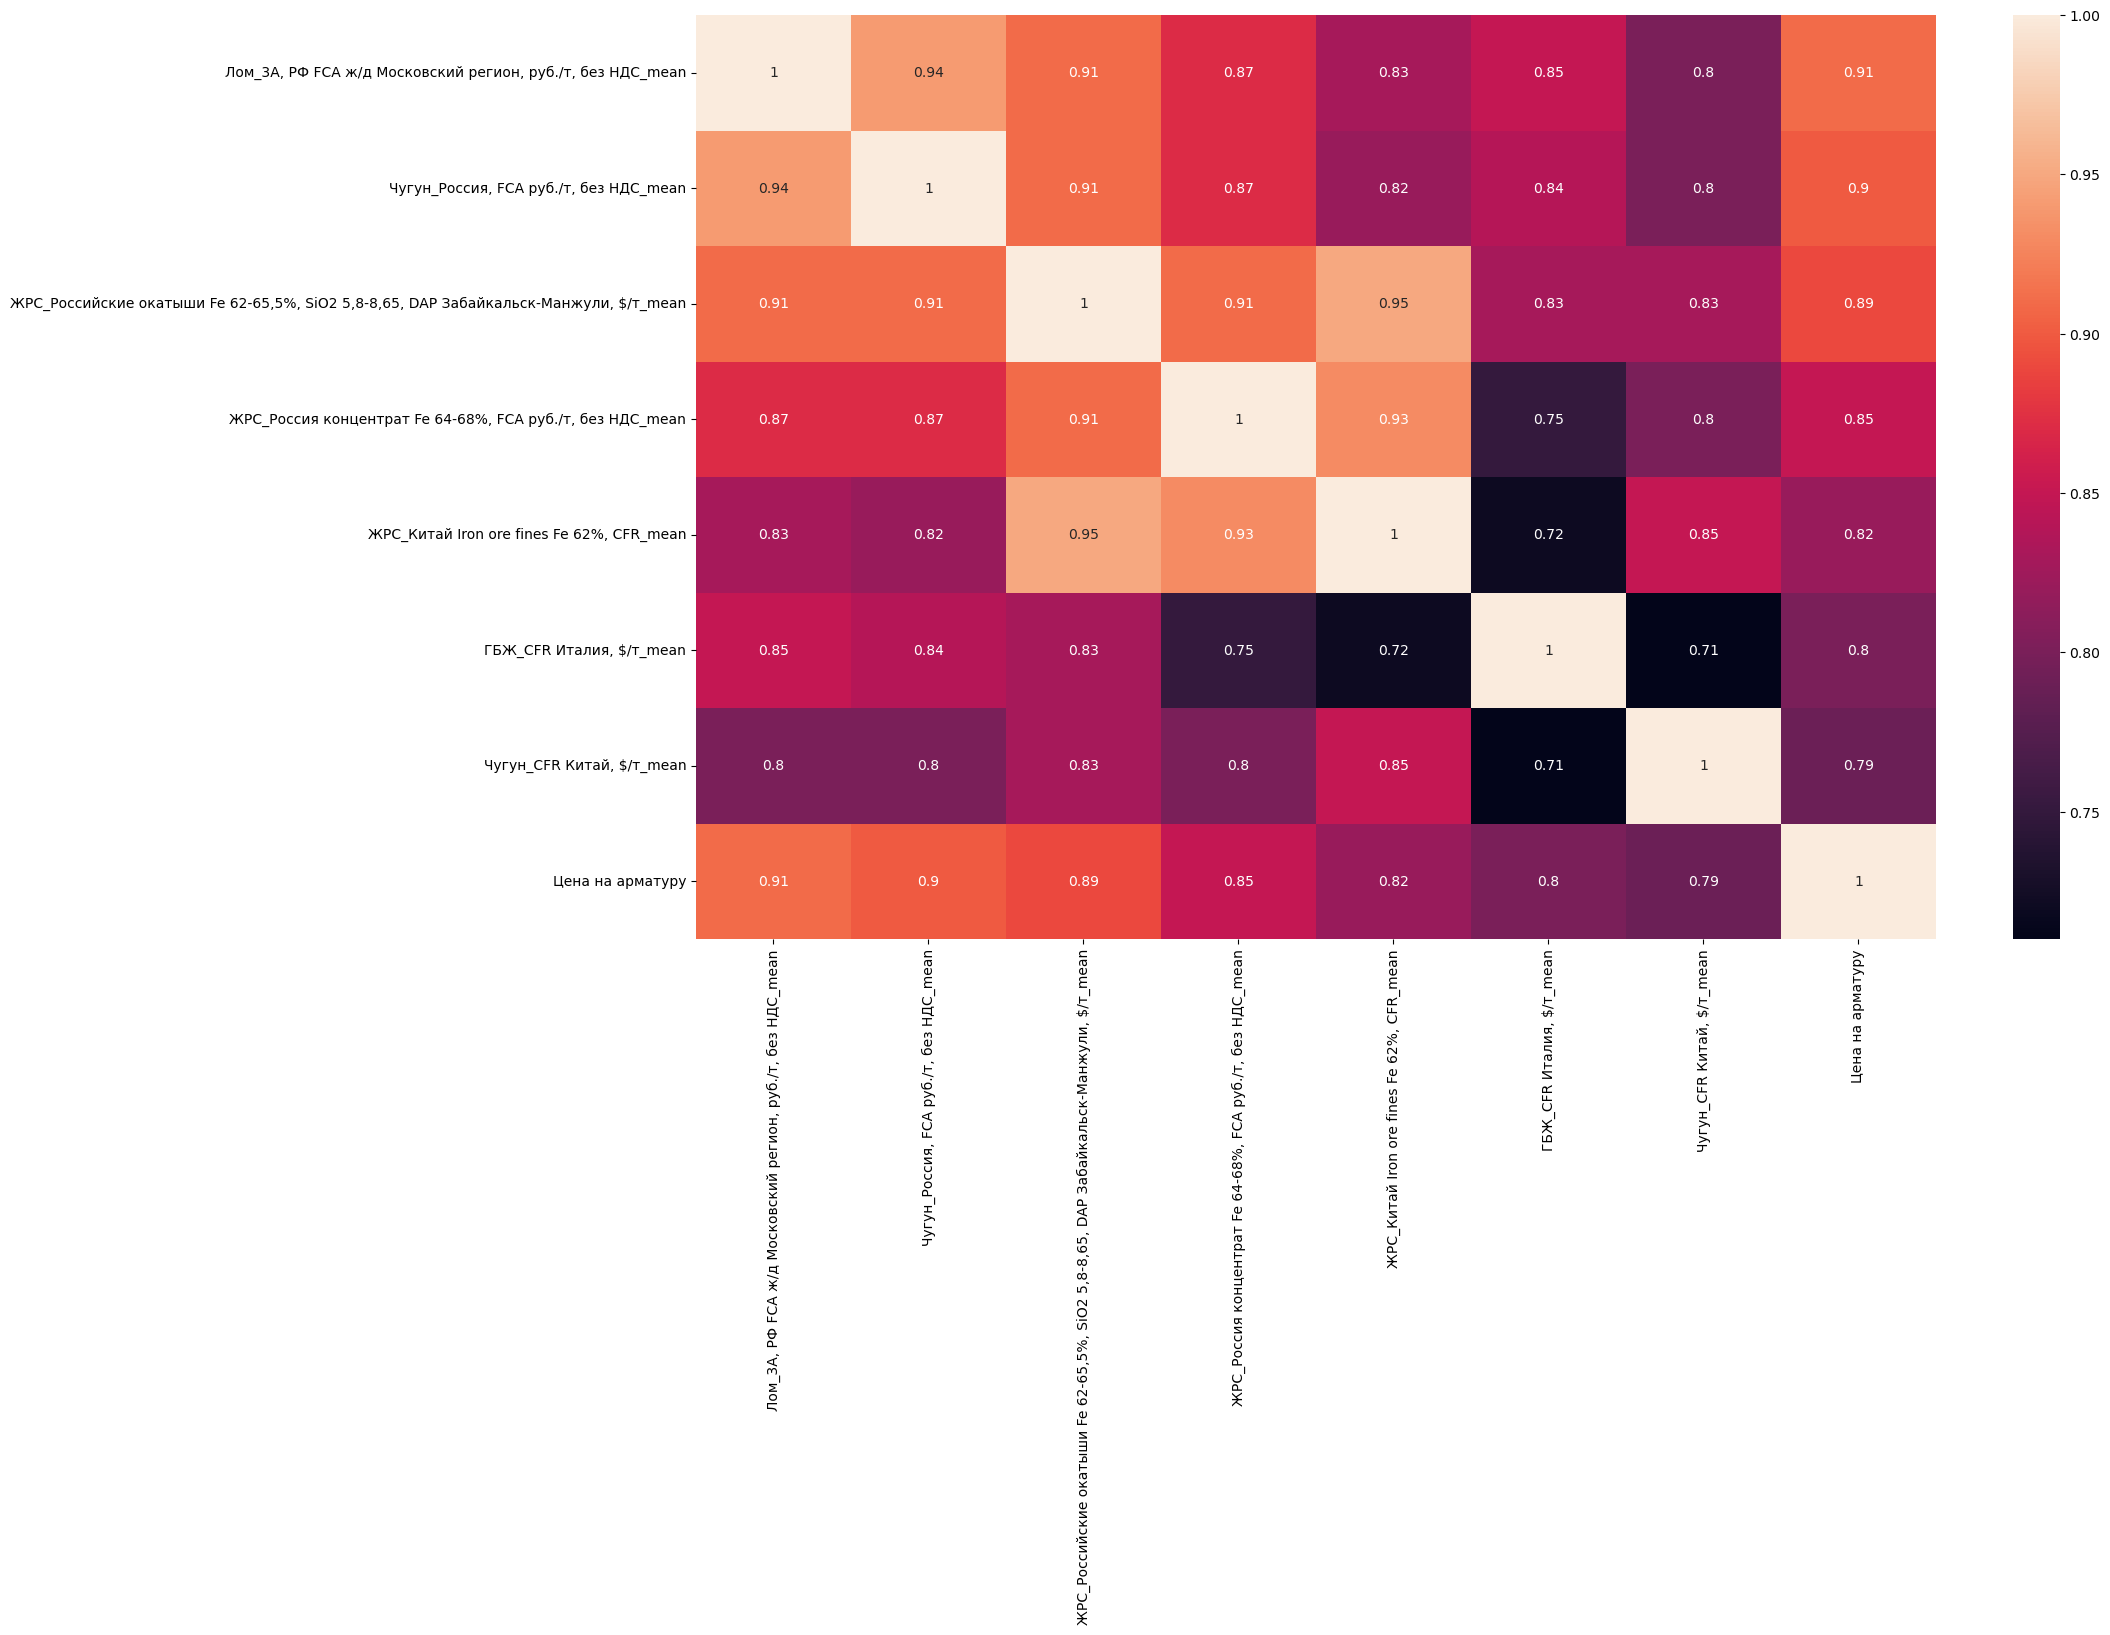

In [35]:
correlation_matrix = np.round(dtrain[corr_features].corr(),2)
fig = plt.figure(figsize=(20,12))
sns.heatmap(data=correlation_matrix, annot=True)

<Figure size 3000x1800 with 0 Axes>

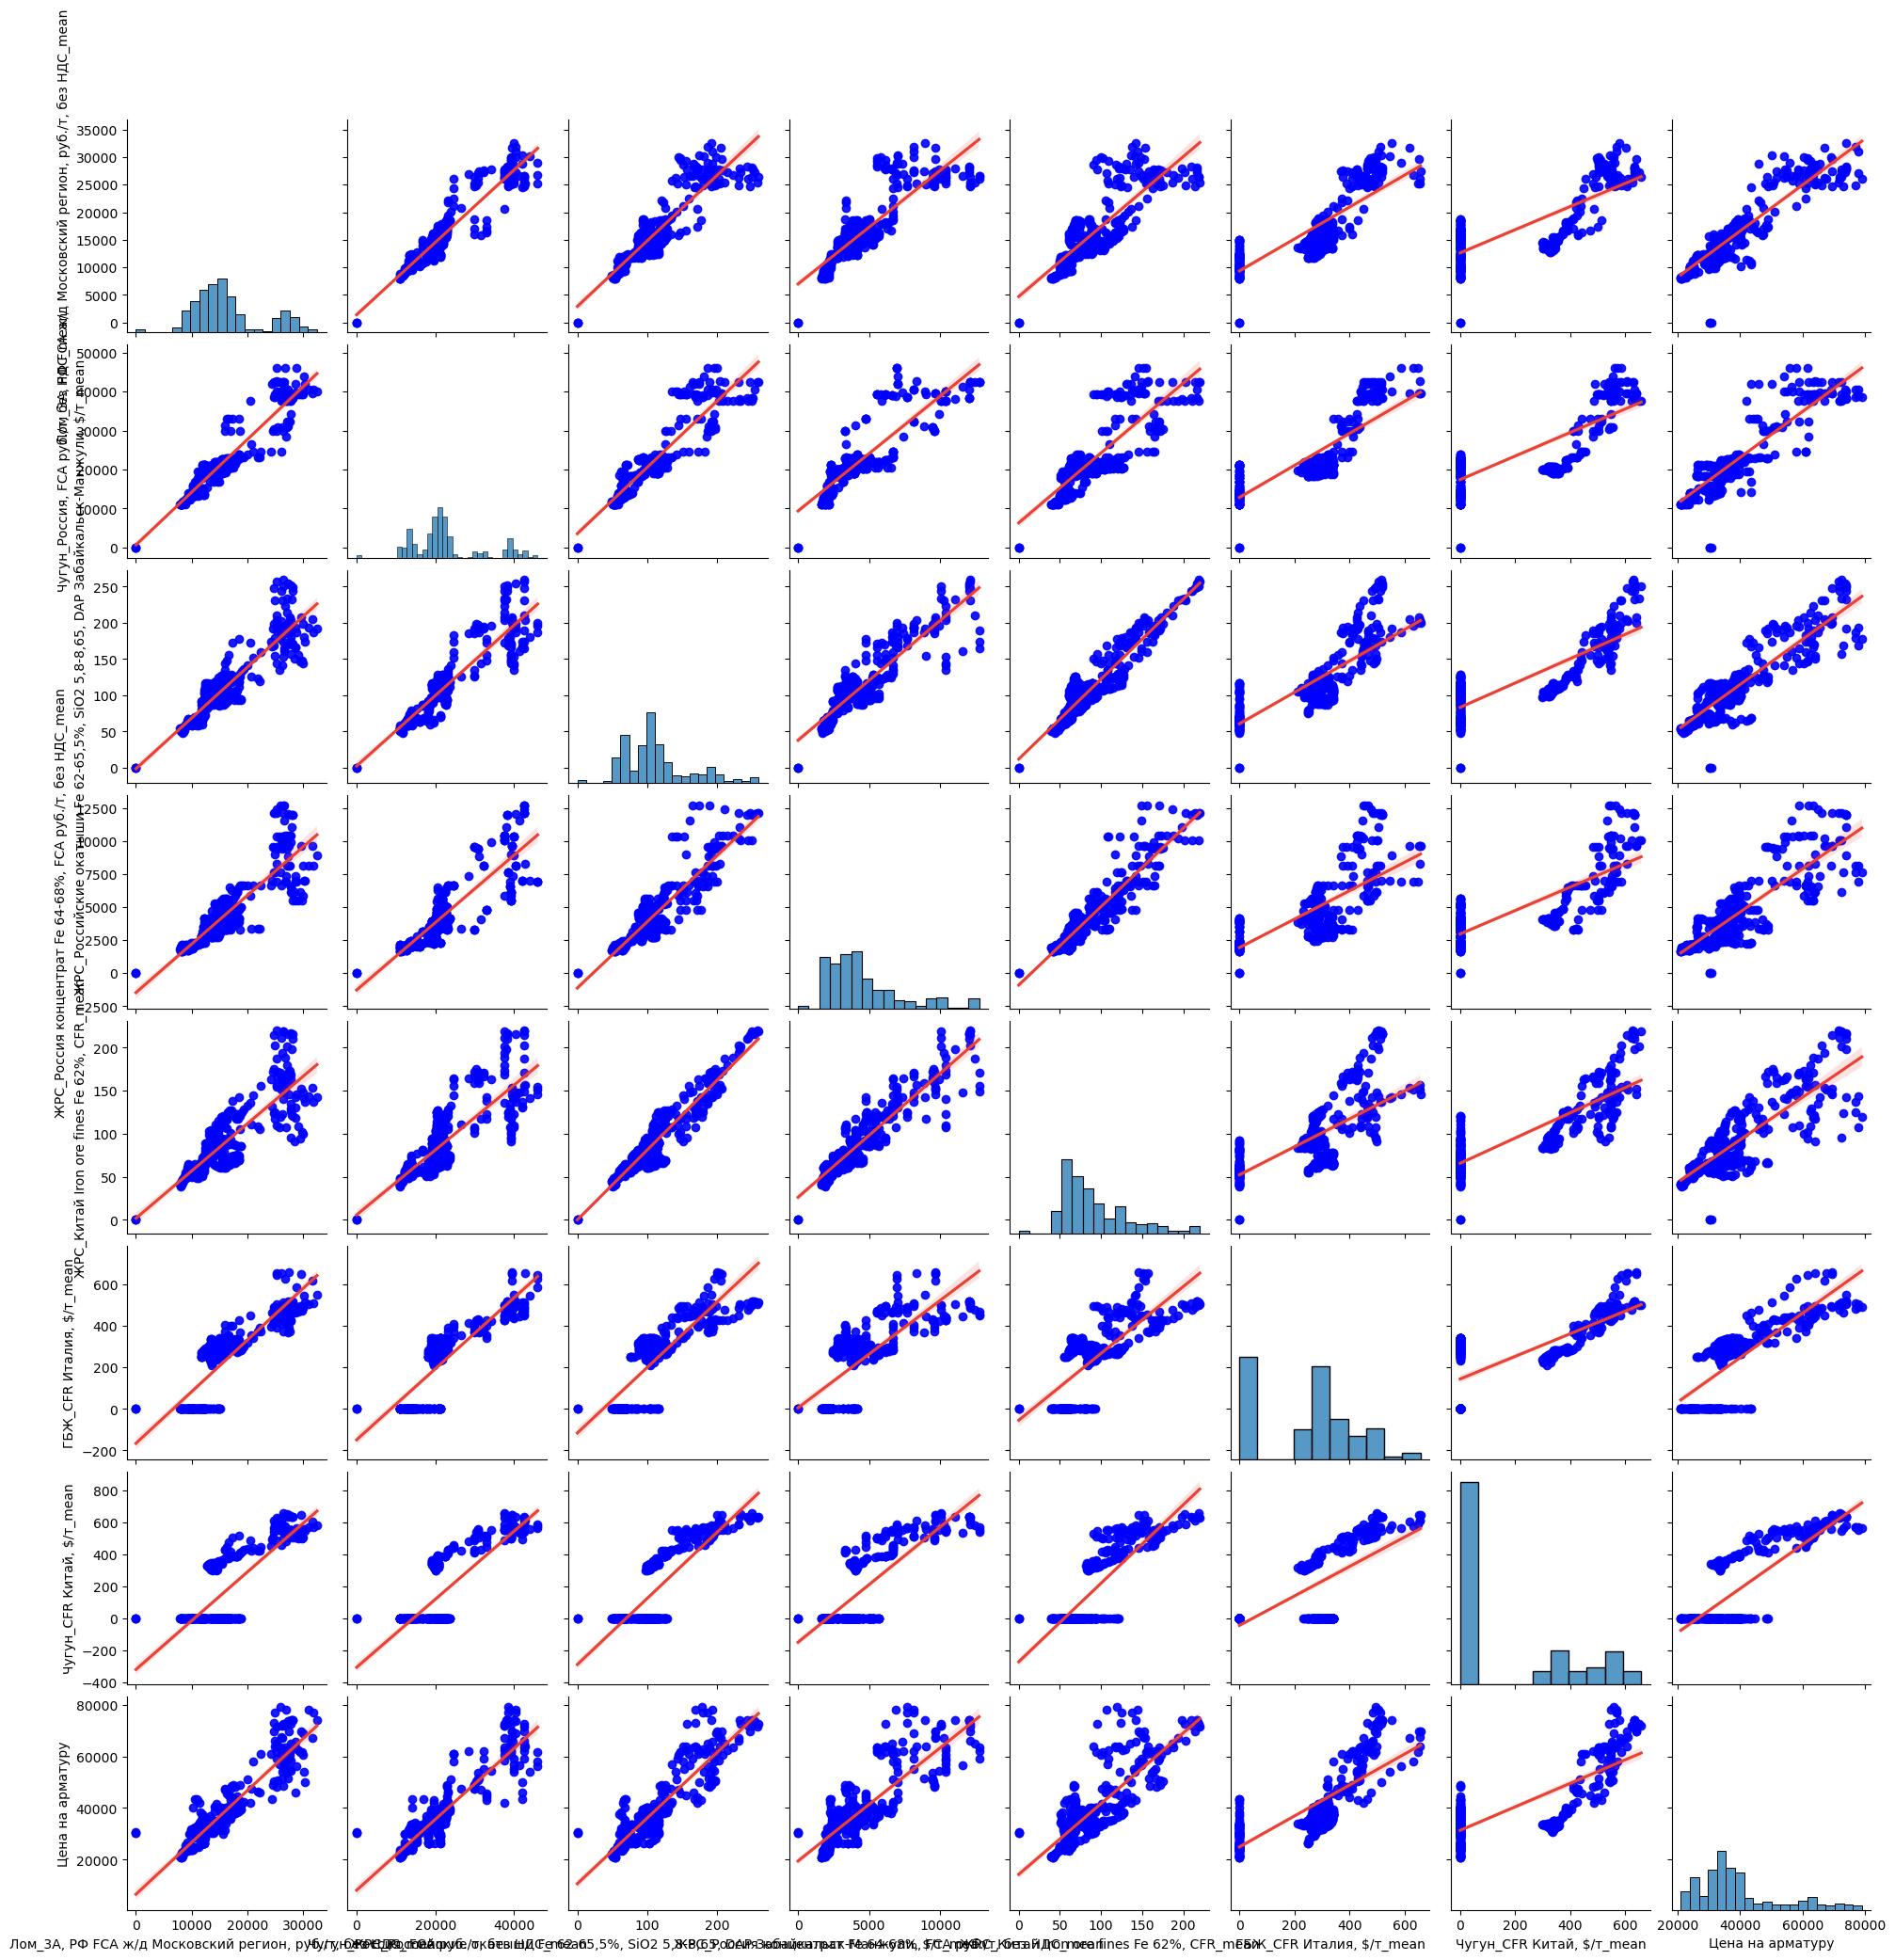

In [36]:
plt.figure(figsize=(30, 18))
sns.pairplot(
    dtrain[corr_features], 
    kind='reg', 
    diag_kind='hist', 
    plot_kws={'line_kws': {'color': '#eb4034'},
    'scatter_kws': {'alpha': 0.9,'color': 'blue'}}
)

plt.show() 

In [37]:
fit =[
    'sin_month_mean',
    'cos_month_mean',
    'sin_day_mean',
    'cos_day_mean',
    'Цена на арматуру'
]

<Figure size 3000x1800 with 0 Axes>

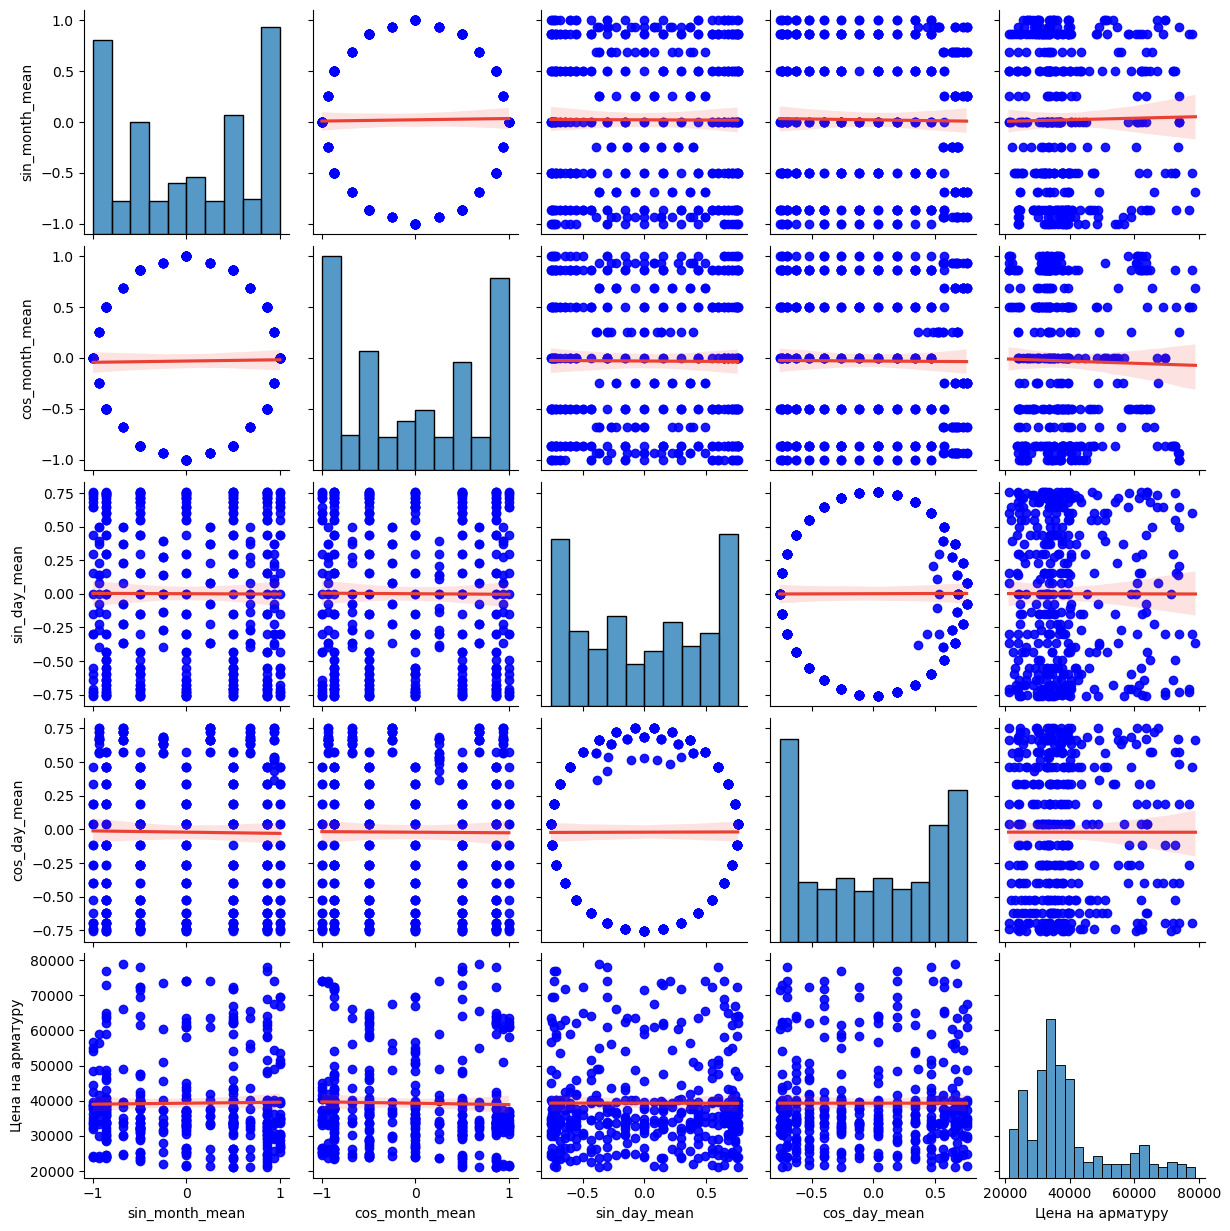

In [38]:
plt.figure(figsize=(30, 18))
sns.pairplot(
    dtrain[fit], 
    kind='reg', 
    diag_kind='hist', 
    plot_kws={'line_kws': {'color': '#eb4034'},
    'scatter_kws': {'alpha': 0.9,'color': 'blue'}}
)

plt.show()

<AxesSubplot:>

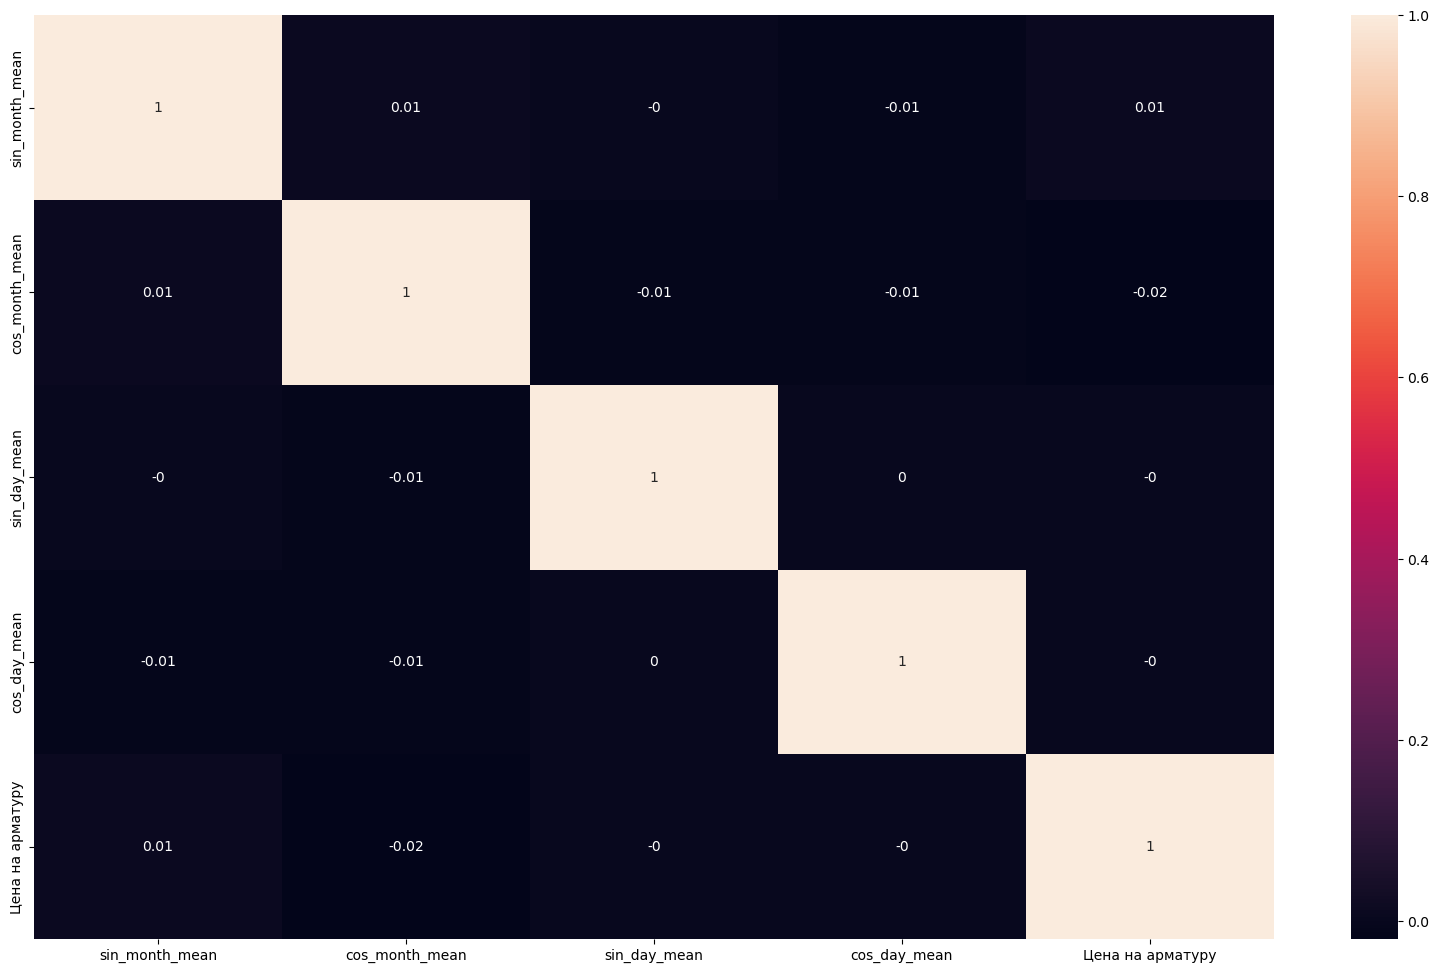

In [39]:
correlation_matrix = np.round(dtrain[fit].corr(),2)
fig = plt.figure(figsize=(20,12))
sns.heatmap(data=correlation_matrix, annot=True)

# Отбор 200 самых важных (по корреляции с целевой переменной) признаков

In [40]:
use = dtrain.corrwith(dtrain["Цена на арматуру"], numeric_only = True).abs().sort_values(ascending = False).head(200).keys().tolist()
use.remove('Цена на арматуру')
use

['Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_mean',
 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_min',
 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_max',
 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС_sum',
 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_mean',
 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_max',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_min',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_mean',
 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_min',
 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС_sum',
 'Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС_min',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_max',
 'Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС_mean',
 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС_sum',
 'Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС_sum',
 'Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС_max',
 'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без Н

# создадим функцию с помощью которой будем обучать модель и прогнозировать на неделю вперед

In [41]:


def model_train(dtrain, dtest):
    kf = KFold(n_splits = 4, shuffle=True, random_state=0)
    predictions = []
    for i, (train_index, test_index) in enumerate(kf.split(dtrain)):
        print(f"Fold {i}:")        
   
        X_train, X_val = dtrain.loc[train_index], dtrain.loc[test_index]
    
        model = CatBoostRegressor(
            learning_rate = 0.1, 
            n_estimators = 30000
        )
        
        model.fit(
            X_train[use],
            X_train[target],
            eval_set = (X_val[use], X_val[target]),
            verbose_eval = 2000,
            early_stopping_rounds = 100)
        predictions.append(model.predict(dtest[use]))
    
    predictions = np.mean(predictions, axis=0)
    return predictions, model

# Здесь получается обучение с подкреплением прогнозируем на одну неделю. Потом данные добавляются в train

In [42]:


train_df = dtrain.copy()
test_df = dtest.copy()
target_df = pd.DataFrame()
models = []

for index, row in test_df.iterrows():
        row['predict_target'], model = model_train(train_df, row)
        train_df = train_df._append(row)
        target_df = target_df._append(row) 
        
        models.append(model)

Fold 0:
0:	learn: 12315.7477389	test: 12537.3160772	best: 12537.3160772 (0)	total: 57.8ms	remaining: 28m 54s
2000:	learn: 36.7432748	test: 1871.9804352	best: 1871.9804352 (2000)	total: 13.8s	remaining: 3m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1871.956146
bestIteration = 3031

Shrink model to first 3032 iterations.
Fold 1:
0:	learn: 12582.7907219	test: 11726.6062769	best: 11726.6062769 (0)	total: 8.96ms	remaining: 4m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2319.37084
bestIteration = 1373

Shrink model to first 1374 iterations.
Fold 2:
0:	learn: 12616.7700873	test: 11540.3870650	best: 11540.3870650 (0)	total: 6.66ms	remaining: 3m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1739.080262
bestIteration = 552

Shrink model to first 553 iterations.
Fold 3:
0:	learn: 11940.6554126	test: 13700.3432169	best: 13700.3432169 (0)	total: 10.9ms	remaining: 5m 25s
Stopped by overfitting detector  (100 iterations w

0:	learn: 12222.8436326	test: 12347.5577233	best: 12347.5577233 (0)	total: 7.71ms	remaining: 3m 51s
2000:	learn: 36.4420590	test: 1630.1070701	best: 1630.1055026 (1982)	total: 14.8s	remaining: 3m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1630.084204
bestIteration = 2528

Shrink model to first 2529 iterations.
Fold 1:
0:	learn: 12879.9463069	test: 10573.8614330	best: 10573.8614330 (0)	total: 8.36ms	remaining: 4m 10s
2000:	learn: 24.7414150	test: 1755.4616437	best: 1755.4616437 (2000)	total: 15.4s	remaining: 3m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1755.429855
bestIteration = 3664

Shrink model to first 3665 iterations.
Fold 2:
0:	learn: 12292.2303308	test: 12258.9738452	best: 12258.9738452 (0)	total: 8.28ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1625.157086
bestIteration = 1276

Shrink model to first 1277 iterations.
Fold 3:
0:	learn: 11766.5044568	test: 13971.6205126	best: 13971.6

Stopped by overfitting detector  (100 iterations wait)

bestTest = 1996.366438
bestIteration = 1028

Shrink model to first 1029 iterations.
Fold 3:
0:	learn: 11948.7668459	test: 13111.0906831	best: 13111.0906831 (0)	total: 8.46ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1527.478929
bestIteration = 1664

Shrink model to first 1665 iterations.
Fold 0:
0:	learn: 11999.9431024	test: 12807.7720975	best: 12807.7720975 (0)	total: 8.82ms	remaining: 4m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1990.454013
bestIteration = 1277

Shrink model to first 1278 iterations.
Fold 1:
0:	learn: 12329.4717491	test: 11660.4127881	best: 11660.4127881 (0)	total: 8.74ms	remaining: 4m 22s
2000:	learn: 24.5413011	test: 2106.8677193	best: 2106.8651039 (1986)	total: 15.1s	remaining: 3m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2106.846118
bestIteration = 2829

Shrink model to first 2830 iterations.
Fold 2:
0:	learn

Stopped by overfitting detector  (100 iterations wait)

bestTest = 1434.006494
bestIteration = 890

Shrink model to first 891 iterations.
Fold 3:
0:	learn: 11795.6864468	test: 12943.6227442	best: 12943.6227442 (0)	total: 9.94ms	remaining: 4m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2179.243889
bestIteration = 1837

Shrink model to first 1838 iterations.
Fold 0:
0:	learn: 12096.4118787	test: 12030.2804750	best: 12030.2804750 (0)	total: 10.4ms	remaining: 5m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2335.992808
bestIteration = 678

Shrink model to first 679 iterations.
Fold 1:
0:	learn: 12143.6485984	test: 12027.7101956	best: 12027.7101956 (0)	total: 11.9ms	remaining: 5m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1309.019905
bestIteration = 1495

Shrink model to first 1496 iterations.
Fold 2:
0:	learn: 12383.1039285	test: 11039.5080095	best: 11039.5080095 (0)	total: 11.1ms	remaining: 5m 31s
Stopped by o

2000:	learn: 40.1159999	test: 2099.9333562	best: 2099.9331304 (1999)	total: 14.6s	remaining: 3m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2099.92555
bestIteration = 2304

Shrink model to first 2305 iterations.
Fold 2:
0:	learn: 12282.5631599	test: 11334.9308217	best: 11334.9308217 (0)	total: 9.25ms	remaining: 4m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1453.495347
bestIteration = 895

Shrink model to first 896 iterations.
Fold 3:
0:	learn: 11921.9026182	test: 12330.1803142	best: 12330.1803142 (0)	total: 8.49ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1718.371216
bestIteration = 609

Shrink model to first 610 iterations.
Fold 0:
0:	learn: 11719.4083919	test: 12996.7055445	best: 12996.7055445 (0)	total: 8ms	remaining: 4m
2000:	learn: 35.5772777	test: 1758.1571034	best: 1758.1562029 (1971)	total: 14.8s	remaining: 3m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1

In [43]:
with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)
    
with open('use.pkl', 'wb') as f:
    pickle.dump(use, f)
    
with open('dtest.pkl', 'wb') as f:
    pickle.dump(dtest, f)

In [44]:
target_df = target_df.set_index("dt")

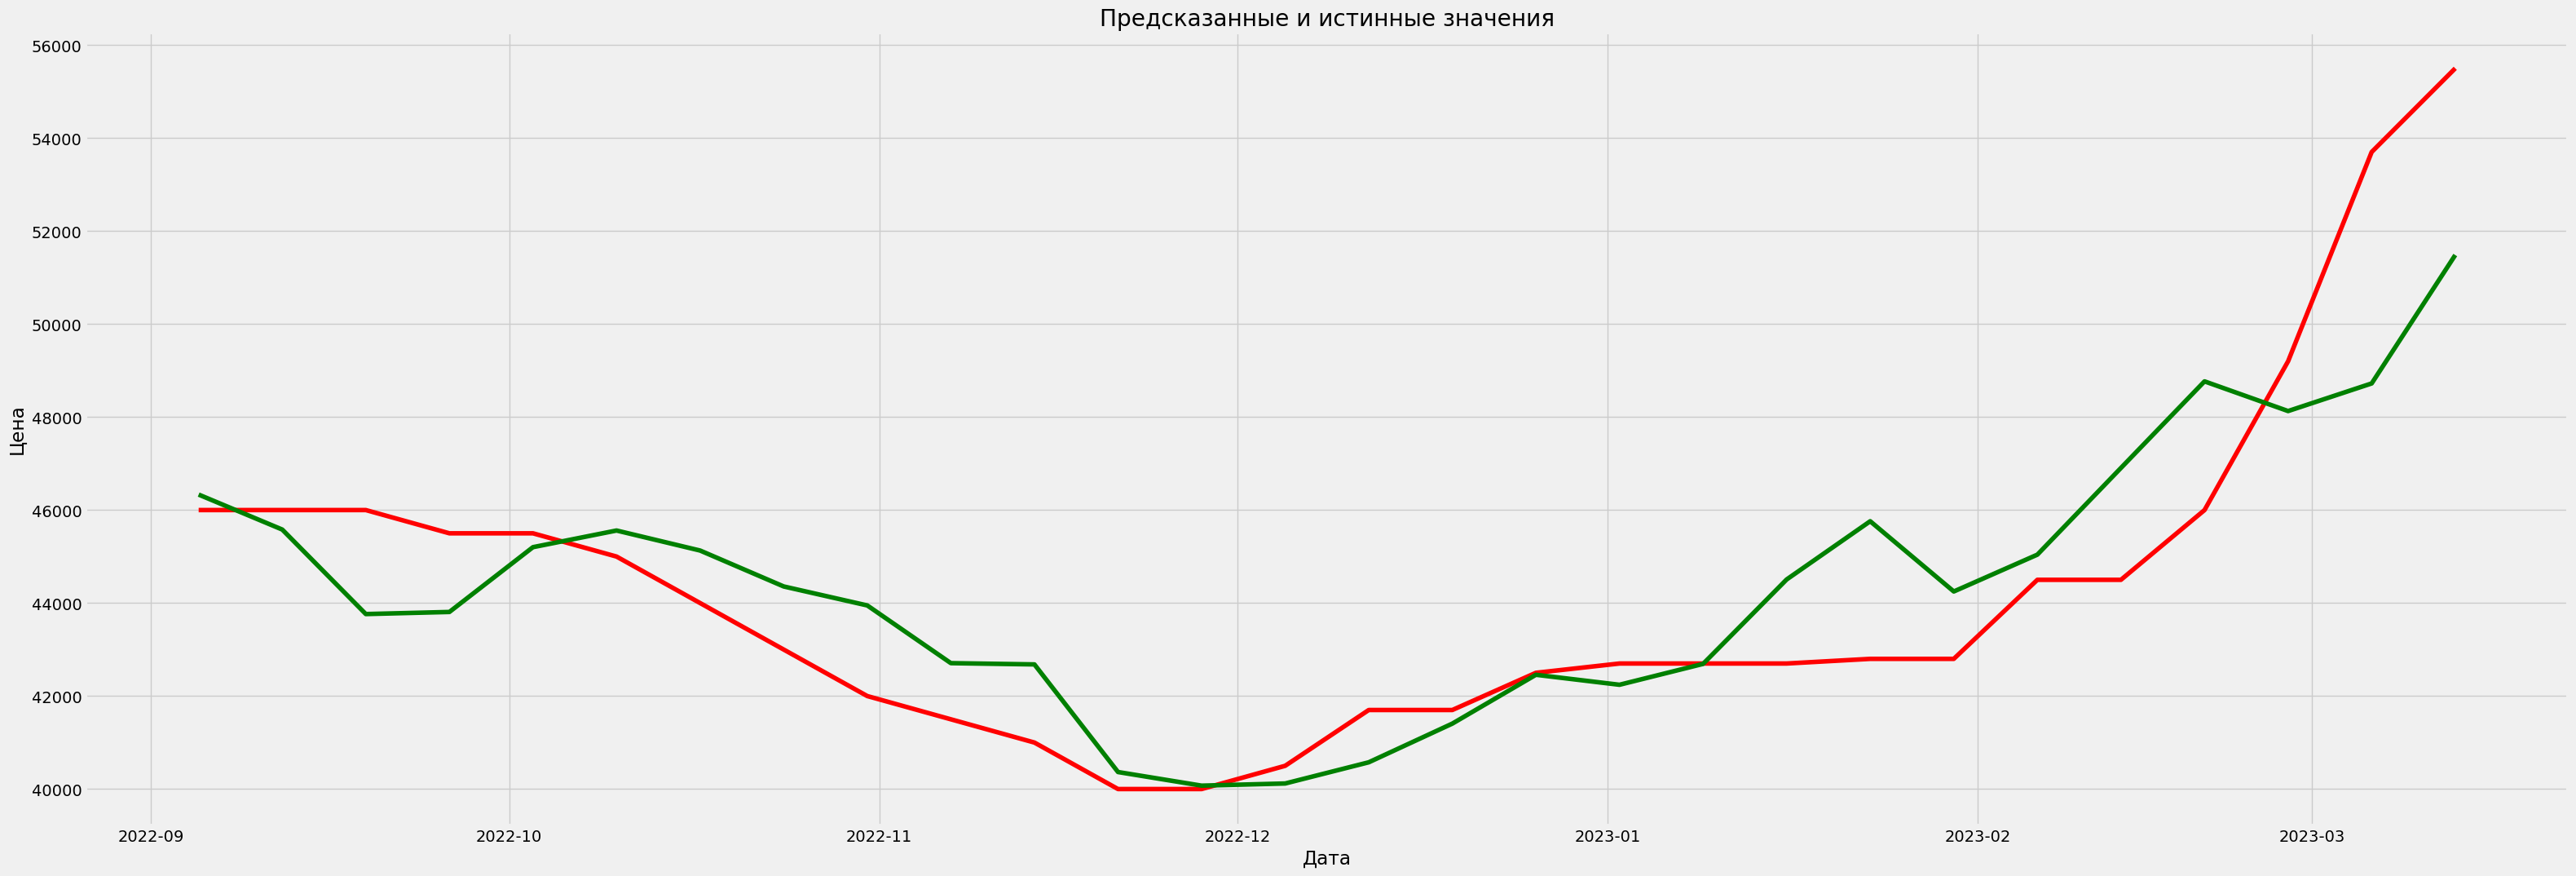

In [45]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(35, 12))
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Предсказанные и истинные значения")
 
plt.plot(target_df['Цена на арматуру'], c = 'r')
plt.plot(target_df['predict_target'], c = 'g')

In [46]:
target_df["predict_target"].min(), target_df["predict_target"].max()

(40073.1611963945, 51484.31944312262)

In [47]:
print(f'RMSE score is {np.sqrt(mean_squared_error(target_df["Цена на арматуру"], target_df["predict_target"]))}')

RMSE score is 1807.7208956867858
